In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw2.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

In [3]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit

In [4]:
# measure notebook runtime
time_start = time.time()

## Notebook Contents
<a id="contents"></a>
- **Dataset Information**
- **Bayesian Logistic Regression with Varying-Intercept Description**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


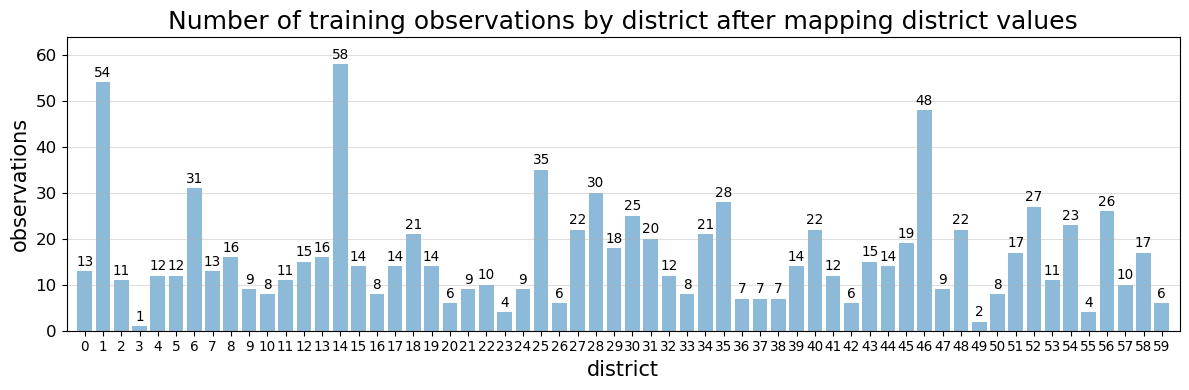

In [5]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 46% to 49% of subjects use contraceptives.**

In [6]:
# set seed for consistency across runs
np.random.seed(109)
# your code here

# Define mu
m_0 = 2
# Define sigma
sigma_0 = 1


Beta_0s = []

# for all 60 districts
for i in range(60):
    
    # Specifying parameters
    Beta_0s.append(np.random.normal(m_0, sigma_0))
    
B1 = 4
B2 = -3
B3 = -2

simulated_Y = []

for i, observation in df_train.iterrows():
    # Casting logistic regression
    prob = Beta_0s[int(observation.district-1)] + B1*observation.urban + B2*observation['living.children'] + B3*observation.age_mean
    # Bernoulli
    prob =np.exp(prob) / (1 + np.exp(prob))
    
    y = np.random.choice([1,0],p=[prob,1-prob])
    simulated_Y.append(y)
    

In [7]:
# Verify that these parameters generate data in which an average of 46% to 49% of 
# subjects use contraceptives.

print("These parameters generate data with an average of {}".format(np.mean(simulated_Y)))

These parameters generate data with an average of 0.48190279214064113


In [8]:
grader.check("q#1.1")

q#1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [9]:
%%time

# your code here

with pm.Model() as model:
    
    # N(0, 100^2)
    mu_0 = pm.Normal("mu_0",mu=0,sigma=100)
    # Gamma(0.1, 0.1)
    tau_0 = pm.Gamma("tau_0",alpha=0.1,beta=0.1)
    
    B0s = pm.Normal("B0s",mu=mu_0,tau = tau_0, shape=60)
    Beta_1 = pm.Normal("Beta_1",mu=0,sigma=100)
    Beta_2 = pm.Normal("Beta_2",mu=0,sigma=100)
    Beta_3 = pm.Normal("Beta_3",mu=0,sigma=100)
    
    p_logit = B0s[df_train.district-1] + Beta_1*df_train.urban + Beta_2*df_train['living.children'] + Beta_3*df_train.age_mean
    
    our_likelihood = pm.Bernoulli('our_likelihood', logit_p= p_logit, observed=simulated_Y)


CPU times: user 90.1 ms, sys: 13.9 ms, total: 104 ms
Wall time: 161 ms


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

_Type your answer here, replacing this text._

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, B0s, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 99 seconds.


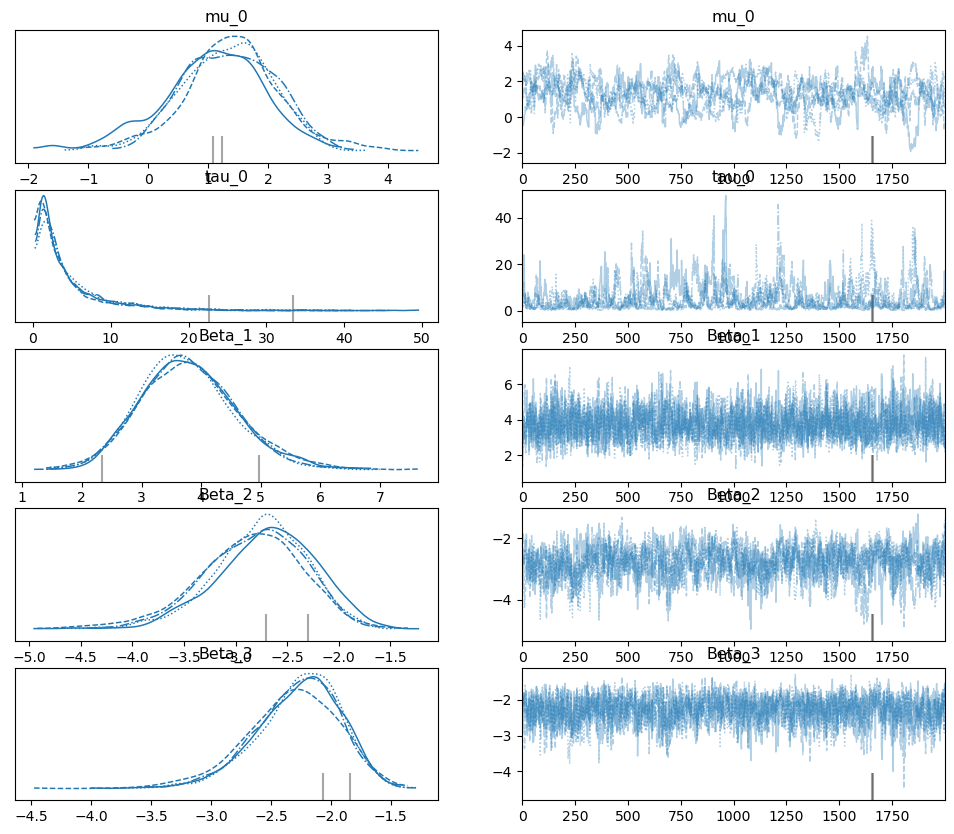

<Figure size 3000x3000 with 0 Axes>

CPU times: user 17.3 s, sys: 730 ms, total: 18.1 s
Wall time: 1min 51s


In [10]:
%%time 
# your code here

# We use the sample function to draw samples from the posterior distribution 
# Number of samples to draw: 2000
# `tune=2000`: number of tuning samples to discard at the beginning of the sampling process
# `target_accept=.9` for the target acceptance rate of the 
#  Metropolis-Hastings algorithm used for sampling
with model:
    
    # The trace variable will contain the samples drawn from the posterior distribution
    trace = pm.sample(draws=2000, chains=4, tune=2000, target_accept=.98)
    # plot the trace plot of the mu0 parameter using Arviz
    az.plot_trace(trace, var_names=["mu_0", "tau_0", "Beta_1", "Beta_2", "Beta_3"])
    plt.figure(figsize=(30,30));
    plt.show()

    
 


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

_Type your answer here, replacing this text._

/opt/conda/lib/python3.10/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (60) in plot_posterior, generating only 40 plots
  warnings.warn(


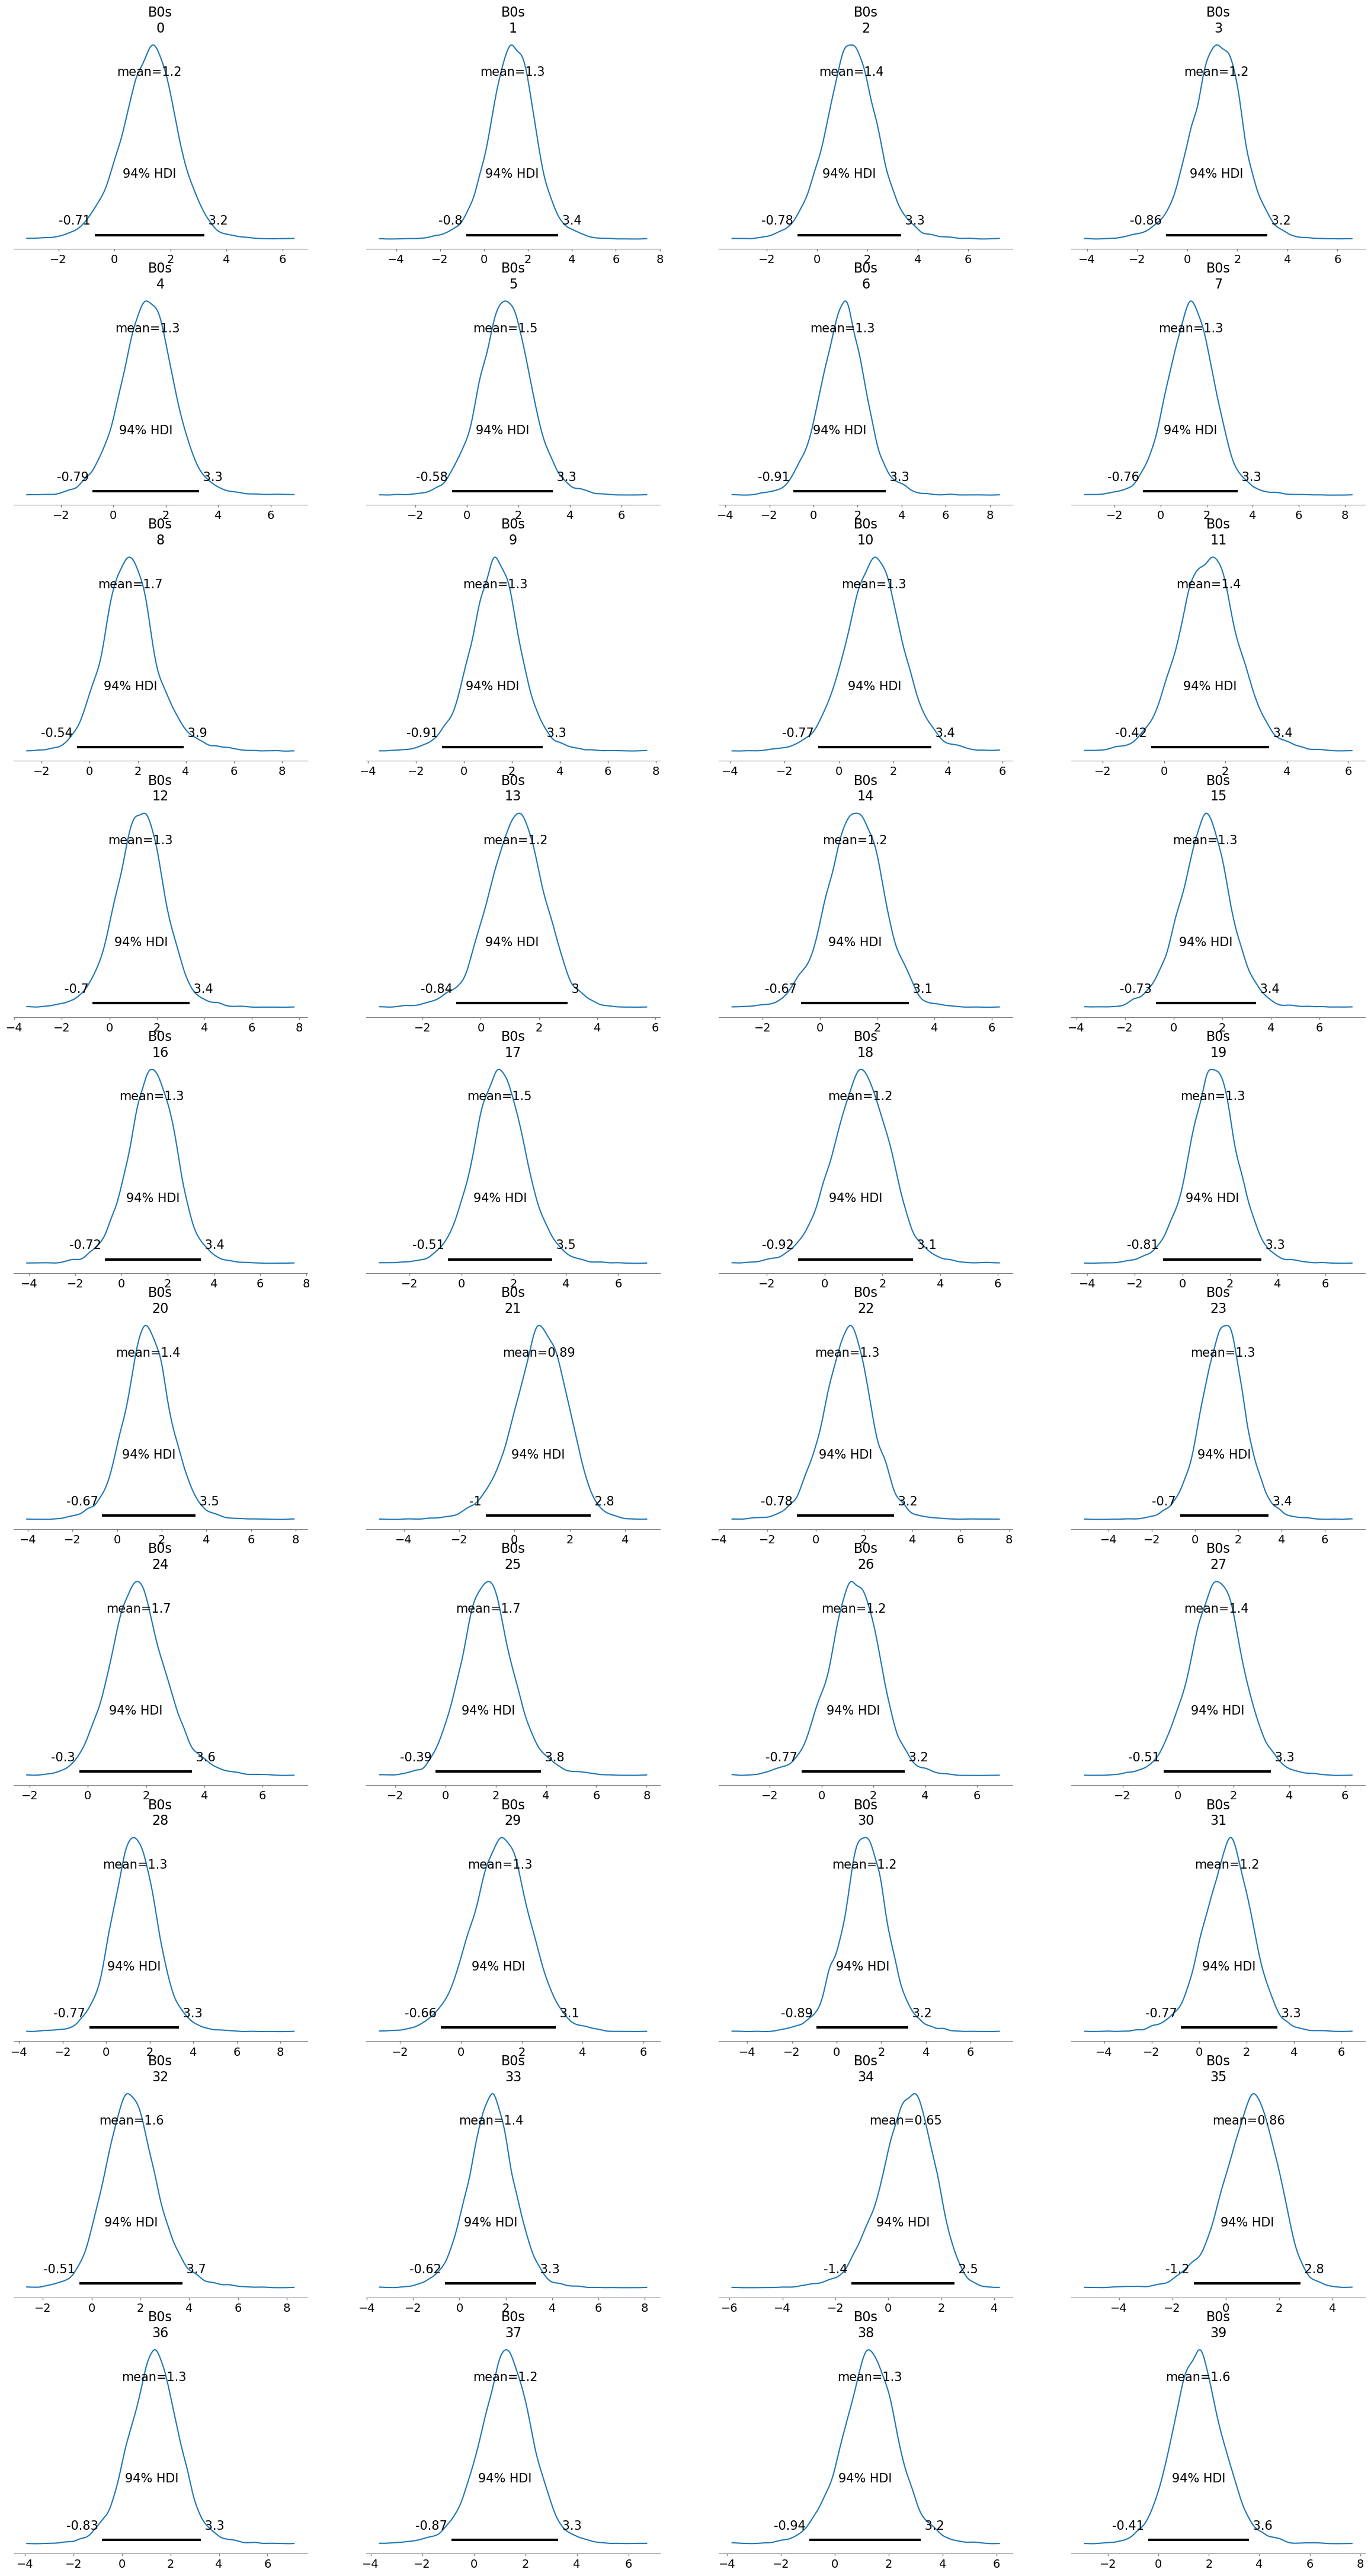

In [11]:
# your code here

az.plot_posterior(trace, var_names=['B0s']);

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [12]:
# your code here

# Storing the real dependent variable
real_train_Y = df_train['contraceptive_use']

with pm.Model() as model:
    
    # N(0, 100^2)
    mu_0 = pm.Normal("mu_0",mu=0,sigma=100)
    # Gamma(0.1, 0.1)
    tau_0 = pm.Gamma("tau_0",0.1,0.1)
    
    B0s = pm.Normal("Beta_0",mu=mu_0,tau = tau_0,shape=60)
    Beta_1 = pm.Normal("Beta_1",mu=0,sigma=100)
    Beta_2 = pm.Normal("Beta_2",mu=0,sigma=100)
    Beta_3 = pm.Normal("Beta_3",mu=0,sigma=100)
    
    p_logit = B0s[df_train.district-1] + Beta_1*df_train.urban + Beta_2*df_train['living.children'] + Beta_3*df_train.age_mean
    
    our_likelihood = pm.Bernoulli('our_likelihood', 
                                  logit_p=p_logit, 
                                  
                                  # Making sure to replace observed data with real data
                                  observed=real_train_Y)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

_Type your answer here, replacing this text._

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, Beta_0, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.


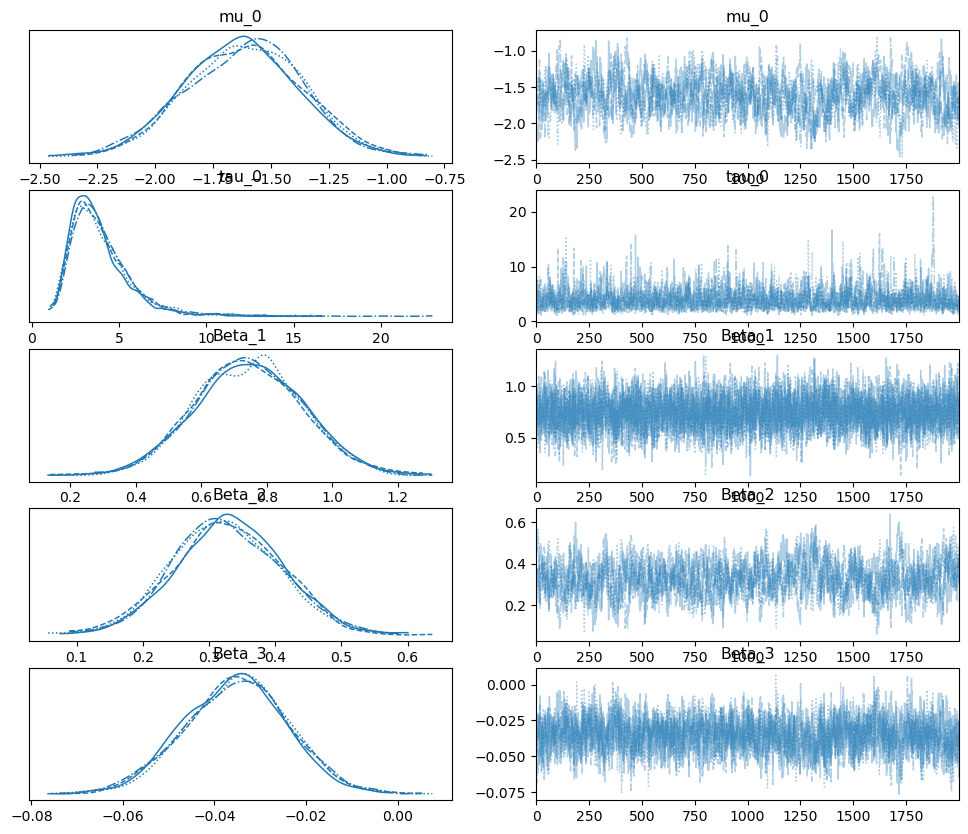

<Figure size 3000x3000 with 0 Axes>

In [13]:
# your code here

# We use the sample function to draw samples from the posterior distribution 
# Number of samples to draw: 2000
# `tune=2000`: number of tuning samples to discard at the beginning of the sampling process
# `target_accept=.9` for the target acceptance rate of the 
#  Metropolis-Hastings algorithm used for sampling
with model:
    
    # The trace variable will contain the samples drawn from the posterior distribution
    trace = pm.sample(draws=2000, chains=4, tune=2000, target_accept=.98)
    # plot the trace plot of the mu0 parameter using Arviz
    az.plot_trace(trace, var_names=["mu_0", "tau_0", "Beta_1", "Beta_2", "Beta_3"])
    plt.figure(figsize=(30,30));
    plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

_Type your answer here, replacing this text._

In [14]:
# your code here

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

_Type your answer here, replacing this text._

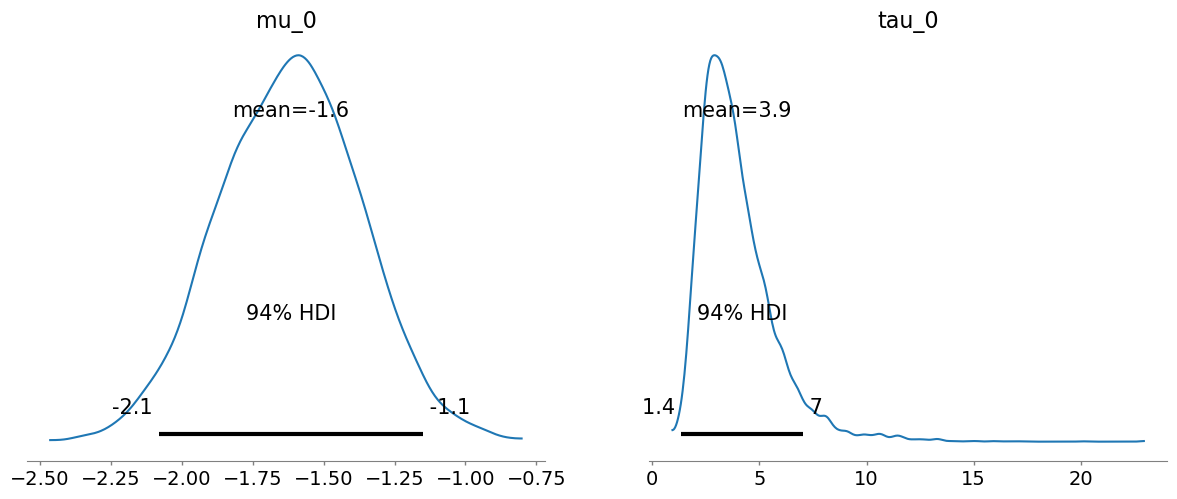

In [15]:
# your code here

az.plot_posterior(trace, var_names=['mu_0', 'tau_0']);


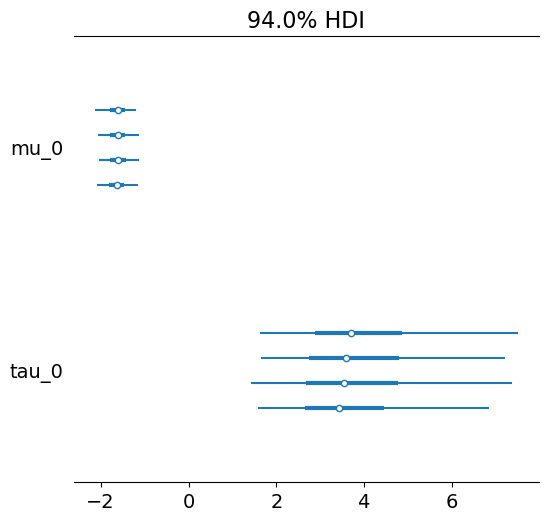

In [16]:
az.plot_forest(trace, var_names=['mu_0', 'tau_0']);

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [17]:
# your code here

with pm.Model() as model:
    
    # N(0, 100^2)
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    
    # Gamma(0.1, 0.1)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    
    B0s = pm.Normal("B0s", mu=mu_0, tau=tau_0, shape=60)
    Beta_1 = pm.Normal("Beta_1", mu=0, tau=tau_0)
    Beta_2 = pm.Normal("Beta_2",mu=0, tau=tau_0)
    Beta_3 = pm.Normal("Beta_3",mu=0, tau=tau_0)
    
    p_logit = B0s[df_train.district-1] + Beta_1*df_train.urban + Beta_2*df_train['living.children'] + Beta_3*df_train.age_mean
    
    our_likelihood = pm.Bernoulli('our_likelihood', logit_p= p_logit, observed=real_train_Y)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

_Type your answer here, replacing this text._

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, B0s, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


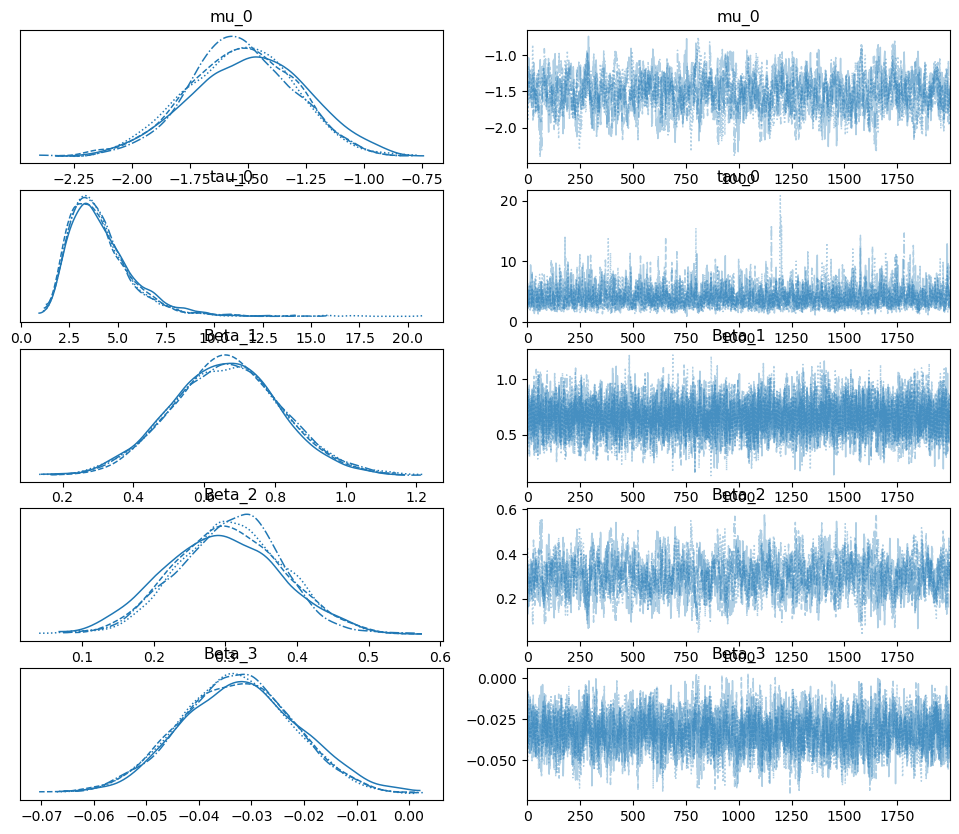

<Figure size 3000x3000 with 0 Axes>

In [18]:
# We use the sample function to draw samples from the posterior distribution 
# Number of samples to draw: 2000
# `tune=2000`: number of tuning samples to discard at the beginning of the sampling process
# `target_accept=.9` for the target acceptance rate of the 
#  Metropolis-Hastings algorithm used for sampling
with model:
    
    # The trace variable will contain the samples drawn from the posterior distribution
    trace = pm.sample(draws=2000, chains=4, tune=2000, target_accept=.98)
    # plot the trace plot of the mu0 parameter using Arviz
    az.plot_trace(trace, var_names=["mu_0", "tau_0", "Beta_1", "Beta_2", "Beta_3"])
    plt.figure(figsize=(30,30));
    plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

_Type your answer here, replacing this text._

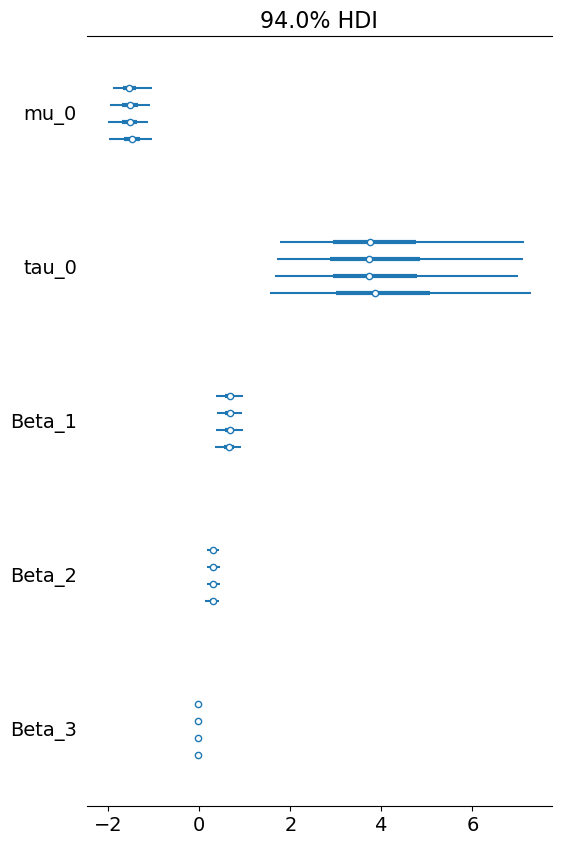

In [19]:
# your code here

az.plot_forest(trace, var_names=["mu_0", "tau_0", "Beta_1", "Beta_2", "Beta_3"]);

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Create and Evaluate Classifiers</b></div>

Build two Bayesian logistic regression classifiers: one from your varying-intercept model (Q2) and another from your varying-coefficients model (Q3). Then, use each model to make predictions on your training and test sets.

* For each of the two classifiers, **on both train and test data separately**, report:
    * percentage of observations predicted to be `1` (i.e., uses contraceptives)
    * accuracy score

Finally, briefly describe the approach you used to implement these classifiers.
  
**Hint:** These classification models will make use of the samples generated by your PyMC models above, but they need not themselves be PyMC model objects. They can also be constructed out of simple Python functions of your own design.

**Approach to build Bayesian Logistic Regression Classifier using Varying-Coefficient model**

(*Please note that the changes that we made to the code are also added as comments within the code itself.*)

As previously, we set up a PyMC model using the `with pm.Model() as model` context manager. That is also where we once again define the prior distributions for each of the model parameters. 

We maintain the 3 $\beta$ coefficients with the same priors as previously. However, we use for the $\beta$ coefficients a different normal distribution than from the previous approach (where the $\beta$ coefficients had the same prior as the intercepts) by setting $\mu = 0$ and $\sigma^2=1$. By using a smaller standard deviation, we are placing a tighter constraint on the possible values for these coefficients. This can help with model convergence and interpretability of the results.

We then define the logit of the probability of success as a linear combination of the intercept and the beta coefficients multiplied by the corresponding predictor variables. To obtain the probability of success `p` (i.e., the probability of contraceptive use), we use the inverse logit function provided by PyMC. This function maps the range of the logit function ($-\infty \rightarrow \infty$) to the range of probabilities (0 to 1).

Finally, we define the likelihood of the data, which is a Bernoulli distribution with the observed values of contraceptive use as the observed data and `p` as the parameter. This means that we are assuming that the observed data are generated from a binary process where the probability of success is $p$.



**Approach to build Bayesian Logistic Regression Classifier using Varying-Intercept model**

(*Please note that the changes that we made to the code are also added as comments within the code itself.*)

Firstly, define prior distributions for model parameters, with the same specifications as previously:

- $\mu$: mean of the varying intercepts, which represent the effect of each district on the dependent variable.
- $\tau$: variance of the varying intercepts.
- $\beta_0$'s: set of varying intercepts for each district.
- $\beta_1, \beta_2, \beta_3$: coefficients for dependent variables

We then compute the linear predictor, which is the sum of the varying intercepts for each district and the product of each independent variable with its corresponding coefficient. The linear predictor is transformed to the logit scale, which is the logarithm of the odds of the dependent variable being 1.

Finally, we define the likelihood function using a Bernoulli distribution, which models the probability of the dependent variable being 1 as a function of the linear predictor. The observed data (i.e., actual contraceptive use status) is used to specify the values of the likelihood function.

To get the accuracy on the training data, we need to sample from the posterior distribution of the model parameters using Markov Chain Monte Carlo (MCMC) simulation. Then, we extract the samples for the model parameters from the MCMC trace. Finally, we use the samples to make predictions on the training data. This can be done by computing the probability of each observation being in the positive class (i.e., contraceptive use) using the logistic function, and then rounding the probabilities to 0 or 1.


In [20]:
# Real test data:

real_test_Y = df_test['contraceptive_use']

In [21]:
###### BAYESIAN LOGISTIC REGRESSION CLASSIFIER USING VARYING-INTERCEPT MODEL ########

# IN Q2.1, the likelihood had a BERNOULLI dist., which is appropriate for modelling binary data
# Instead of using a varying intercept model, we need to use a model that allows the coefficients of the 
# independent variables to vary across the different levels of the `district` variable

# Storing the real dependent variable
real_train_Y = df_train['contraceptive_use']

with pm.Model() as model:
    
    # N(0, 100^2) prior for the mean of the varying intercepts
    mu_0 = pm.Normal("mu_0",mu=0,sigma=100)
    
    # Gamma(0.1, 0.1) prior for the variance of the varying intercepts
    tau_0 = pm.Gamma("tau_0",0.1,0.1)
    
    # Define the varying intercepts for each district using a Normal distribution
    # with mean mu_0 and variance tau_0
    # We specify the shape of the distribution to be the number of unique values of
    # the 'district' variable in the training data
    B0s = pm.Normal("B0s", mu=mu_0, tau=tau_0, shape=len(np.unique(df_train.district)))
    
    # Define the coefficients for the independent variables
    Beta_1 = pm.Normal("Beta_1", mu=0, sigma=100)
    Beta_2 = pm.Normal("Beta_2", mu=0, sigma=100)
    Beta_3 = pm.Normal("Beta_3", mu=0, sigma=100)
    
    # Compute the linear predictor by adding up the varying intercepts for each district
    # and the product of each independent variable with its corresponding coefficient
    p_logit = B0s[df_train.district-1] + Beta_1*df_train.urban + Beta_2*df_train['living.children'] + Beta_3*df_train.age_mean
    
    # Define the likelihood function using a Bernoulli distribution with parameter
    # p = 1/(1+exp(-p_logit)) to model the binary outcome variable
    our_likelihood = pm.Bernoulli('our_likelihood', p=pm.math.invlogit(p_logit), observed=real_train_Y)

In [22]:
# Sample from the posterior distribution
with model:
    trace = pm.sample(1000, tune=1000, chains=4)

    # Extract the samples for the model parameters
    B0_samples = trace['B0s']
    Beta_1_samples = trace['Beta_1']
    Beta_2_samples = trace['Beta_2']
    Beta_3_samples = trace['Beta_3']

# Make predictions on the training data
n = len(real_train_Y)
y_pred = np.zeros(n)

for i in range(n):
    # Compute the probability of contraceptive use for this observation
    p = 0
    for j in range(len(np.unique(df_train.district))):
        B0 = B0_samples[:, j]
        p_logit = B0[df_train['district'][i]-1] + Beta_1_samples*df_train['urban'][i] + Beta_2_samples*df_train['living.children'][i] + Beta_3_samples*df_train['age_mean'][i]
        p += np.mean(1 / (1 + np.exp(-p_logit)))
    p /= len(np.unique(df_train.district))
    
    # Assign a class based on the probability of contraceptive use
    y_pred[i] = int(p >= 0.5)

# Compute the accuracy score
accuracy = np.mean(y_pred == real_train_Y)
print('Accuracy:', accuracy)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, B0s, Beta_1, Beta_2, Beta_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


KeyError: 'B0s'

In [ ]:
###### BAYESIAN LOGISTIC REGRESSION CLASSIFIER USING VARYING-COEFFICIENT MODEL ########

with pm.Model() as model:
    
    # N(0, 100^2)
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    
    # Gamma(0.1, 0.1)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    
    B0s = pm.Normal("B0s", mu=mu_0, tau=tau_0, shape=60)
    
    # Change prior for Beta_1, Beta_2, and Beta_3 to Normal with mean 0 and sigma 10
    # This prior is more appropriate for logistic regression, as it allows for a wider range of plausible values 
    # for the regression coefficients
    
    Beta_1 = pm.Normal("Beta_1", mu=0, sigma=10)
    Beta_2 = pm.Normal("Beta_2", mu=0, sigma=10)
    Beta_3 = pm.Normal("Beta_3", mu=0, sigma=10)
    
    p_logit = B0s[df_train.district-1] + Beta_1*df_train.urban + Beta_2*df_train['living.children'] + Beta_3*df_train.age_mean
    
    # Add logistic function to convert logit to probability
    p = pm.math.invlogit(p_logit)
    
    # Change likelihood function to Bernoulli with p as parameter
    our_likelihood = pm.Bernoulli("our_likelihood", p=p, observed=real_train_Y)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Comparison to Naive Model</b></div>

Report the same four metrics from the previous question for a 3rd, "naive" model that always predicts the most frequent outcome observed in the training data.

In [ ]:
# your code here
...

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 - Model Selection</b></div>

What do you conclude from the results of 4.1 & 4.2? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

_Type your answer here, replacing this text._

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

_Type your answer here, replacing this text._

In [ ]:
time_spent_on_hw = ...

In [ ]:
grader.check("q4.4")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW2. Thank you!**